# D8-D9 FWD_BWD [Transfer score]

CT MODEL PERFORMANCE ON DAY 8 AND DAY 9

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../..')
from data_import import*
from helper import*
from plot_params import*
import seaborn as sns
import scipy.stats
pp = PlotParams()
import scipy as sp

## Import the predicted RT datafiles

In [5]:
f4_path = '/Users/szekelyanna/f4/cogtom/cogtom_code_bt/Python/Output/NOGTHSH/'
fig_save_path = '/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/across_sessions_d8_d9/'
file = 'NOGTHSH_ACROSS_SESSIONS_d8_d9_across_session_NOG_d9_216_225_23_09_11.csv'
data_tag, data = import_and_transform_data(f4_path, file)
print(data_tag)

Nr of datapoints: 329,446 
chains:['saw' 'camino' 'scissors' 'silkroad'] 
train:['186_195' '216_225'], test:['176_185' '201_214'] 
data used: NOGTHSH_ACROSS_SESSIONS_d8_d9_across_session_NOG_d9_216_225_23_09_11.csv


In [6]:
file = 'NOGTHSH_ACROSS_SESSIONS_d7_d8_across_session_NOG_23_09_05.csv'
data_d7_d8 = import_and_transform_data(f4_path, file)
data_d7_d8_tag, data_d7_d8_raw = data_d7_d8
print(data_d7_d8_tag)

Nr of datapoints: 278,152 
chains:['saw' 'scissors' 'camino' 'silkroad'] 
train:['161_170' '186_195'], test:['151_160' '176_185'] 
data used: NOGTHSH_ACROSS_SESSIONS_d7_d8_across_session_NOG_23_09_05.csv


## Functions for data transformations

In [7]:
def drop_RTs_above_3std(data):
    rt_means = dict(data.groupby('participant')['rt'].mean())
    participants = rt_means.keys()
    rt_means = np.array(data.groupby('participant')['rt'].mean())
    rt_std = np.array(data.groupby('participant')['rt'].std())
    rt_mean_3std = rt_means + 3*rt_std
    rt_mean_3std = dict(zip(participants, rt_mean_3std))
    data['rt_means_3std'] = data['participant'].map(rt_mean_3std)
    data = data.loc[data['rt'] < data['rt_means_3std']]
    return (data)

In [8]:
def corr_computation(data):
    corr_matrix = (data
                           .groupby(['model', 'participant', 'e_train', 'e_test', 'day'])
                           [['rt','rt_predicted']]
                           .corr())

    corr_matrix.reset_index(inplace = True)
    corr_matrix.drop(['level_5', 'rt'], axis = 1, inplace = True)
    matrix = corr_matrix.loc[corr_matrix['rt_predicted'] !=1]
    matrix['r_sqr'] = matrix.rt_predicted**2
    matrix.drop('rt_predicted', 1, inplace = True)
    #data =  matrix.drop('day', axis = 1)
    #data = data.groupby(['model', 'participant', 'e_train', 'e_test']).sum()
    return (matrix)

In [9]:
def data_pivot_add_diffs(data):
    data = data.pivot(index = ['day', 'participant', 'e_test'], columns = ['model'], values = ['r_sqr'])
    data = data.unstack(0)
    colnames = [item[1:3] for item in data.columns]
    data.columns = pd.MultiIndex.from_tuples(colnames, names=["model", "day"])
    
    #add_diffs
    #data['GT_diff'] = data[('GroundTruth', 9.0)] - data[('GroundTruth', 8.0)]
    data['iHMM_diff'] = data[('iHMM', 9.0)] - data[('iHMM', 8.0)]
    
    
    return (data)

In [10]:
def data_pivot_add_diffs2(data):
    data = data.pivot(index = ['day', 'participant', 'e_test'], columns = ['model'], values = ['r_sqr'])
    data = data.unstack(0)
    colnames = [item[1:3] for item in data.columns]
    data.columns = pd.MultiIndex.from_tuples(colnames, names=["model", "day"])
    
    #add_diffs
    #data['GT_diff'] = data[('GroundTruth', 8.0)] - data[('GroundTruth', 7.0)]
    data['iHMM_diff'] = data[('iHMM', 8.0)] - data[('iHMM', 7.0)]
    
    return (data)

## Transform the D8-D9 crossover data 

In [11]:
data_d8_d9 = corr_computation(drop_RTs_above_3std(data))
data_d8_d9 = data_pivot_add_diffs(data_d8_d9)

/var/folders/j5/sdcqcn450vj04kd1_kb4xv6c0000gn/T/ipykernel_63693/2566535092.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix['r_sqr'] = matrix.rt_predicted**2
/var/folders/j5/sdcqcn450vj04kd1_kb4xv6c0000gn/T/ipykernel_63693/2566535092.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  matrix.drop('rt_predicted', 1, inplace = True)
/Users/szekelyanna/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re

In [12]:
data_d8_d9.rename(columns = {8.0:'CT_D8', 9.0: 'CT_D9', '': 'iHMM_diff'}, inplace = True)
data_d8_d9 = data_d8_d9.droplevel(0, axis = 1)
data_d8_d9.reset_index(inplace = True)

In [13]:
data_d8_d9.loc[data_d8_d9['e_test'].isin(['176_185']), 'test_day'] = 'D8'
data_d8_d9.loc[data_d8_d9['e_test'].isin(['201_214']), 'test_day'] = 'D9'

In [14]:
data_d8_d9.loc[data_d8_d9['test_day'] == 'D8', 'corresp_advtg'] = data_d8_d9['CT_D8'] -  data_d8_d9['CT_D9']  
data_d8_d9.loc[data_d8_d9['test_day'] == 'D9', 'corresp_advtg'] = data_d8_d9['CT_D9'] -  data_d8_d9['CT_D8']  

In [15]:
data_d8_d9_cross = (data_d8_d9[['participant', 'test_day', 'corresp_advtg']]
                                  .groupby(['participant', 'test_day'])
                                  .mean()
                                  .unstack()
                   )

data_d8_d9_cross = data_d8_d9_cross.droplevel(0, axis = 1)#.columns.name = None
data_d8_d9_cross.columns.name = None
data_d8_d9_cross.reset_index(inplace=True);

## Transform the D7-D8 crossover data

In [16]:
data_d7_d8 = corr_computation(drop_RTs_above_3std(data_d7_d8_raw))
data_d7_d8 = data_pivot_add_diffs2(data_d7_d8)

/var/folders/j5/sdcqcn450vj04kd1_kb4xv6c0000gn/T/ipykernel_63693/2566535092.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix['r_sqr'] = matrix.rt_predicted**2
/var/folders/j5/sdcqcn450vj04kd1_kb4xv6c0000gn/T/ipykernel_63693/2566535092.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  matrix.drop('rt_predicted', 1, inplace = True)


In [17]:
data_d7_d8.rename(columns = {7.0:'CT_D7', 8.0: 'CT_D8', '': 'iHMM_diff'}, inplace = True)
data_d7_d8 = data_d7_d8.droplevel(0, axis = 1)
data_d7_d8.reset_index(inplace = True)

In [18]:
data_d7_d8.loc[data_d7_d8['e_test'].isin(['151_160']), 'test_day'] = 'D7'
data_d7_d8.loc[data_d7_d8['e_test'].isin(['176_185']), 'test_day'] = 'D8'

data_d7_d8.loc[data_d7_d8['test_day'] == 'D7', 'corresp_advtg'] = data_d7_d8['CT_D7'] -  data_d7_d8['CT_D8']  
data_d7_d8.loc[data_d7_d8['test_day'] == 'D8', 'corresp_advtg'] = data_d7_d8['CT_D8'] -  data_d7_d8['CT_D7']  

In [19]:
data_d7_d8_cross = (data_d7_d8[['participant', 'test_day', 'corresp_advtg']]
                                  .groupby(['participant', 'test_day'])
                                  .mean()
                                  .unstack()
                   )

data_d7_d8_cross = data_d7_d8_cross.droplevel(0, axis = 1)#.columns.name = None
data_d7_d8_cross.columns.name = None
data_d7_d8_cross.reset_index(inplace=True);

## Merge the D7 and D8 datasets

In [20]:
data_d7_d8_cross.set_index('participant', inplace = True)
data_d8_d9_cross.set_index('participant', inplace = True)
data_d8_d9_cross.rename(columns = {'D8':'d8d9_D8', 'D9':'d8d9_D9'}, inplace = True)
data_d7_d8_cross.rename(columns = {'D7':'d7d8_D7', 'D8':'d7d8_D8'}, inplace = True)
cross_data = pd.concat([data_d8_d9_cross, data_d7_d8_cross], axis=1)
cross_data.reset_index(inplace=True)

## Manuscript plots

In [21]:
def get_x_jitter(df, columns,jitter = 0.05):
    
    '''
    Columns expected to be a list. 
    
    '''
    jitter = jitter
    x_jitter = pd.DataFrame(np.random.normal(loc=0,
                                             scale=jitter, 
                                             size=df.values.shape),
                                             columns=df.columns)
    # ennek a sornak az a lényege, hogy növekvő értékűvé tegye a random noise data-t. 
    # Tehát az első oszlophoz 0-t, a másidikhoz 1-et adok hozzá hozzá. 

    x_jitter[columns] += np.arange(len(columns))
    return (x_jitter[columns])

In [22]:
def plot_crossover(data = data, columns = 'columns', title = None, colors = ['#fa9a50', '#006366'], legend = False): #axes = ax,
    
    '''
    This function is to make the plotting a bit more easy to overview. 
    
    '''
    
    data.participant = data.participant.astype('int')
    x_jitter = get_x_jitter(data, columns)


    means = []
    for col in data[columns]:
        
            means.append(data[col].mean())
            ax.plot(x_jitter.loc[:, col], data.loc[:, col], 'o', zorder=1, ms=pp.markersize_matplotlib, color = pp.basic_color, alpha = 0.8)
            ax.set_xticks([0, 1])
            ax.set_xticklabels([item[-2:] for item in columns], fontsize = pp.ticklabsize)
            ax.set_xlim(-0.5,1.5)
            ax.set_ylim(-.15,.35)
            ax.set_yticks([0, 0.2])
            ax.set_yticklabels([0, 0.2], fontsize = pp.ticklabsize)

    for idx in data.index:
        ax.plot(x_jitter.loc[idx, columns],
                data.loc[idx, columns],
                color = 'grey', 
                linewidth = 0.3, linestyle = '--', zorder=-1)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.axhline(y = 0, color = 'brown', linewidth = 1)
        #####
        ax.set_title(title, size = 34, y = 1.1)
        ax.set_ylabel('Relative performance', fontsize = pp.axlabsize)
        
        if legend: 
            
            handles, labels = ax[c].get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), frameon = False, fontsize = 24, loc = (-0.02,0.8))
    
    
    plt.plot(0, means[0], marker = 'X', markersize = 16, color = '#ff8c00', mew = 1)
    plt.plot(1, means[1], marker = 'X', markersize = 16, color = '#ff8c00', mew = 1)

In [23]:
x_jitter = get_x_jitter(cross_data, cross_data.columns[1:])

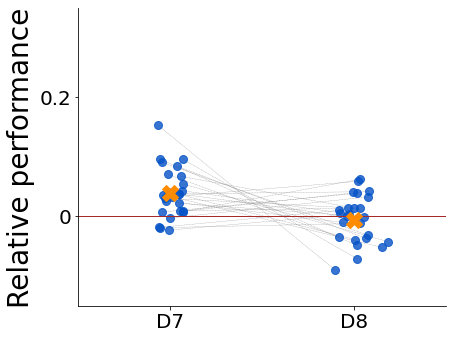

In [24]:
fig, ax = plt.subplots(1, 1,  figsize = pp.figsize, facecolor = 'white')
plot_crossover(data = cross_data, columns = ['d7d8_D7', 'd7d8_D8'], legend = False)
fig.tight_layout()

In [25]:
# fig.savefig('/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/manuscript_plots_standard/' +'transfer_test_D7_D8.pdf', bbox_inches='tight')
# fig.savefig('/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/manuscript_plots_standard/' +'transfer_test_D7_D8.png', bbox_inches='tight')

## T tests for D7-D8 crossover

In [26]:
res = scipy.stats.ttest_1samp(cross_data['d7d8_D7'].dropna(), popmean = 0)
(print (f'Independent t-test t-value: {res.statistic:.3f}, p-value: {res.pvalue:.3f}{get_stars(res.pvalue)}, df:{res.df}.'))
res = scipy.stats.ttest_1samp(cross_data['d7d8_D8'].dropna(), popmean = 0)
(print (f'Independent t-test t-value: {res.statistic:.3f}, p-value: {res.pvalue:.3f}{get_stars(res.pvalue)}, df:{res.df}.'))


print('\n****\nprevious stats: Independent t-test t-value: 3.506, p-value: 0.002**, df:22.\nIndependent t-test t-value: -0.573, p-value: 0.572, df:22. \nDegrees of freedom = 22')

Independent t-test t-value: 4.685, p-value: 0.000***, df:24.
Independent t-test t-value: -0.652, p-value: 0.520, df:24.

****
previous stats: Independent t-test t-value: 3.506, p-value: 0.002**, df:22.
Independent t-test t-value: -0.573, p-value: 0.572, df:22. 
Degrees of freedom = 22


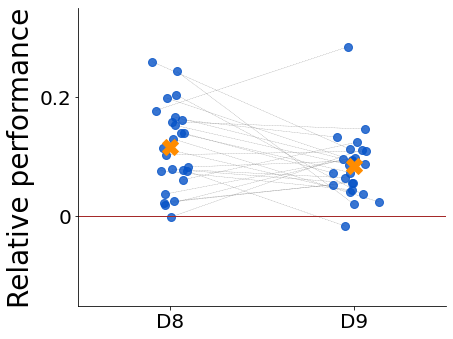

In [27]:
fig, ax = plt.subplots(1, 1,  figsize = pp.figsize, facecolor = 'white', sharey = False)
plot_crossover(data = cross_data, columns = ['d8d9_D8', 'd8d9_D9'])
fig.tight_layout()

In [28]:
# fig.savefig('/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/manuscript_plots_standard/' +'transfer_test_D8_D9.pdf', bbox_inches='tight')
# fig.savefig('/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/plots/manuscript_plots_standard/' +'transfer_test_D8_D9.png', bbox_inches='tight')

## T-tests for D8-D9 crossover

In [29]:
res = scipy.stats.ttest_1samp(cross_data['d8d9_D8'].dropna(), popmean = 0)
(print (f'Independent t-test t-value: {res.statistic:.3f}, p-value: {res.pvalue:.3f}{get_stars(res.pvalue)}, df:{res.df}.'))
res = scipy.stats.ttest_1samp(cross_data['d8d9_D9'].dropna(), popmean = 0)
(print (f'Independent t-test t-value: {res.statistic:.3f}, p-value: {res.pvalue:.3f}{get_stars(res.pvalue)}, df:{res.df}.'))

Independent t-test t-value: 8.204, p-value: 0.000***, df:24.
Independent t-test t-value: 7.426, p-value: 0.000***, df:24.


# ANOVA to check whether D8-D9 means are higher than the D7-D8 means

In [30]:
res = scipy.stats.f_oneway(cross_data['d7d8_D7'].dropna(),
                     cross_data['d7d8_D8'].dropna(),
                     cross_data['d8d9_D8'].dropna(),
                     cross_data['d8d9_D8'].dropna()
                    )
(print (f'Anova f value: {res.statistic:.3f}, p-value: {res.pvalue:.3f}{get_stars(res.pvalue)}.'))


print('previous stats: Anova f value: 12.740, p-value: 0.000***')

Anova f value: 26.861, p-value: 0.000***.
previous stats: Anova f value: 12.740, p-value: 0.000***


In [31]:
print(cross_data['d7d8_D8'].dropna().shape)
print(cross_data['d7d8_D8'].dropna().shape)

print(cross_data['d8d9_D8'].dropna().shape)
print(cross_data['d8d9_D8'].dropna().shape)

(25,)
(25,)
(25,)
(25,)


In [32]:
result = scipy.stats.tukey_hsd(cross_data['d7d8_D7'].dropna(), ## group 0
                               cross_data['d7d8_D8'].dropna(), ## group 1
                               cross_data['d8d9_D8'].dropna(), ## group 2
                               cross_data['d8d9_D8'].dropna()  ## group 3
                           )

In [33]:
print(result)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.045     0.037     0.002     0.088
 (0 - 2)     -0.077     0.000    -0.120    -0.034
 (0 - 3)     -0.077     0.000    -0.120    -0.034
 (1 - 0)     -0.045     0.037    -0.088    -0.002
 (1 - 2)     -0.122     0.000    -0.164    -0.079
 (1 - 3)     -0.122     0.000    -0.164    -0.079
 (2 - 0)      0.077     0.000     0.034     0.120
 (2 - 1)      0.122     0.000     0.079     0.164
 (2 - 3)      0.000     1.000    -0.043     0.043
 (3 - 0)      0.077     0.000     0.034     0.120
 (3 - 1)      0.122     0.000     0.079     0.164
 (3 - 2)      0.000     1.000    -0.043     0.043



In [34]:
## várakozások: 0 alacsonyabb a 2. 3-nál - ok. 
##              1 alacsonyabb a 2. 3-nák - ok. 
##              2 magasabb a 0-nál és 1-nél
##              3 magasabb a 0-nál és 1-nél.


## MEANS

In [35]:
mean = cross_data.d8d9_D8.mean()
std = cross_data.d8d9_D8.std()
print(f'D8-D9 comparison D8 mean: {mean:.3f}, std {std:.3f}')


mean = cross_data.d8d9_D9.mean()
std = cross_data.d8d9_D9.std()
print (f'D8-D9 comparison D9 mean: {mean:.3f}, std {std:.3f}')


mean = cross_data.d7d8_D7.mean()
std = cross_data.d7d8_D7.std()
print(f'D7-D8 comparison D7 mean: {mean:.3f}, std {std:.3f}')


mean = cross_data.d7d8_D8.mean()
std = cross_data.d7d8_D8.std()
print (f'D7-D8 comparison D8 mean: {mean:.3f}, std {std:.3f}')

D8-D9 comparison D8 mean: 0.116, std 0.071
D8-D9 comparison D9 mean: 0.084, std 0.057
D7-D8 comparison D7 mean: 0.040, std 0.042
D7-D8 comparison D8 mean: -0.005, std 0.040


Previous stats:

D8-D9 comparison D8 mean: 0.105, std 0.091

D8-D9 comparison D9 mean: 0.095, std 0.074

D7-D8 comparison D7 mean: 0.038, std 0.052

D7-D8 comparison D8 mean: -0.006, std 0.049

### TRANSFER SCORE vs. zigzag score

In [36]:
cross_data['D8D9_transfer_score'] = cross_data['d8d9_D8']*cross_data['d8d9_D9']*100

In [37]:
cross_data.set_index('participant', inplace = True)
cross_data.isnull().sum()

d8d9_D8                0
d8d9_D9                0
d7d8_D7                0
d7d8_D8                0
D8D9_transfer_score    0
dtype: int64

In [40]:
zigzagscore = pd.read_csv('/Users/szekelyanna/Dropbox/CSNL/cognitive_tomography/analysis_2022/data/zigzagscore_no_missing.csv')
zigzagscore.set_index('participant', inplace = True)
cross_data = cross_data.join(zigzagscore)

r=0.504, p=0.010*


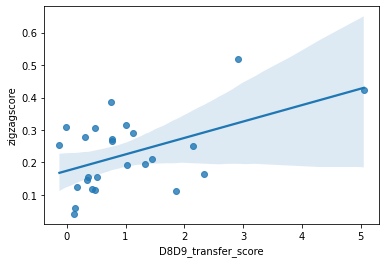

In [41]:
sns.regplot(data = cross_data, x = 'D8D9_transfer_score', y = 'zigzagscore')
r, p = sp.stats.pearsonr(x=cross_data.D8D9_transfer_score, y=cross_data.zigzagscore)
print ('r={:.3f}, p={:.3f}{}'.format(r, p, get_stars(p)));